In [1]:
import os
os.chdir("..")
print("Current Directory:", os.getcwd())

Current Directory: /workspace/iscat


In [2]:
import h5py
import numpy as np
particle_data_path ='dataset/brightfield_particles.hdf5'
with h5py.File(particle_data_path , 'r') as f:
    print(f['data'].shape)
    print(np.unique(f['labels'],return_counts=True))

(41350, 16, 201)
(array([0, 1, 2, 3]), array([32462,  8659,    60,   169]))


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Use DejaVu Serif as an alternative to Times New Roman
rcParams['font.family'] = 'DejaVu Serif'
rcParams['font.size'] = 12
rcParams['axes.titlesize'] = 14
rcParams['axes.labelsize'] = 12
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
rcParams['legend.fontsize'] = 10

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import h5py
import numpy as np
# from torchvision.models import vit_b_16
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from torchvision.models.vision_transformer import VisionTransformer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, f1_score, balanced_accuracy_score
import matplotlib.pyplot as plt

def compute_normalization_stats(h5_path, classes=None):
    """
    Compute mean and standard deviation for z-score normalization.
    
    Args:
        h5_path (str): Path to HDF5 file
        classes (list, optional): List of classes to include in computation
        
    Returns:
        tuple: (mean, std) computed across all data points
    """
    with h5py.File(h5_path, 'r') as h5_file:
        data = h5_file['data'][:]
        labels = h5_file['labels'][:]
        
        if classes is not None:
            # Filter data for selected classes
            mask = np.isin(labels, classes)
            data = data[mask]
        
        # Compute statistics across all dimensions
        mean = np.mean(data)
        std = np.std(data)
        
        print(f"Computed statistics: mean = {mean:.4f}, std = {std:.4f}")
        
        return mean, std
        
class ParticleDataset(Dataset):
    """Custom Dataset for particle data with flexible class selection and normalization."""
    def __init__(self, h5_path, classes=[0, 1], transform=None, mean=None, std=None,padding=False):
        self.h5_file = h5py.File(h5_path, 'r')
        data = self.h5_file['data'][:]
        labels = self.h5_file['labels'][:]
        self.padding = padding
        # Filter data for selected classes
        mask = np.isin(labels, classes)
        self.data = data[mask]
        self.labels = labels[mask]
        
        # Create class mapping to handle non-consecutive class indices
        self.class_to_idx = {c: i for i, c in enumerate(classes)}
        self.num_classes = len(classes)
        
        # Map original labels to new consecutive indices
        self.labels = np.array([self.class_to_idx[label] for label in self.labels])
        
        self.transform = transform
        self.mean = mean
        self.std = std
        
    def __len__(self):
        return len(self.labels)
    
    # def __getitem__(self, idx):
    #     # Get particle data
    #     particle = self.data[idx]  # Shape: (16, 201)
        
    #     # Apply normalization if mean and std are provided
    #     if self.mean is not None and self.std is not None:
    #         particle = (particle - self.mean) / self.std
        
    #     # First resize to (16, 192) using cubic interpolation
    #     # Convert to torch tensor for better interpolation
    #     particle_tensor = torch.FloatTensor(particle).unsqueeze(0)  # Add channel dim
    #     resized = torch.nn.functional.interpolate(
    #         particle_tensor.unsqueeze(0),  # Add batch dim
    #         size=(16, 192),
    #         mode='bicubic',
    #         align_corners=True
    #     ).squeeze(0).squeeze(0)  # Remove batch and channel dims
    #     if self.padding:
    #         # Create square tensor with symmetric padding
    #         target_size = 224
    #         current_height = resized.shape[0]
    #         current_width = resized.shape[1]
        
    #         # Calculate padding for height and width
    #         padding_height = target_size - current_height
    #         padding_width = target_size - current_width
        
    #         # Calculate symmetric padding for height
    #         padding_top = padding_height // 2
    #         padding_bottom = padding_height - padding_top
        
    #         # Calculate symmetric padding for width
    #         padding_left = padding_width // 2
    #         padding_right = padding_width - padding_left
        
    #         # Use torch's pad function for symmetric padding
    #         padded = torch.nn.functional.pad(
    #             resized,
    #             (padding_left, padding_right,  # Padding in width dimension
    #              padding_top, padding_bottom),  # Padding in height dimension
    #             mode='constant',
    #             value=0
    #         )
    #         # Add single channel dimension
    #         final_tensor = padded.unsqueeze(0)
    #     else:
    #         final_tensor = resized.unsqueeze(0)
    #     final_tensor = final_tensor.repeat(3, 1, 1)
    #     if self.transform:
    #         final_tensor = self.transform(final_tensor)
        
    #     # Create one-hot encoded label
    #     label_idx = self.labels[idx]
    #     label_onehot = torch.zeros(self.num_classes)
    #     label_onehot[label_idx] = 1
        
    #     return final_tensor, label_onehot
    def __getitem__(self, idx):
        # Get particle data
        particle = self.data[idx]  # Shape: (16, 201)
        
        # Apply normalization if mean and std are provided
        if self.mean is not None and self.std is not None:
            particle = (particle - self.mean) / self.std
        
        # Convert to torch tensor for better interpolation
        particle_tensor = torch.FloatTensor(particle).unsqueeze(0)  # Add channel dim
        
        # Resize to (16, 16) using bicubic interpolation
        resized = torch.nn.functional.interpolate(
            particle_tensor.unsqueeze(0),  # Add batch dim
            size=(16, 16),
            mode='bicubic',
            align_corners=True
        ).squeeze(0).squeeze(0)  # Remove batch and channel dims
        
        final_tensor = resized.unsqueeze(0).repeat(3, 1, 1)  # Repeat across 3 channels
        
        if self.transform:
            final_tensor = self.transform(final_tensor)
        
        # Create one-hot encoded label
        label_idx = self.labels[idx]
        label_onehot = torch.zeros(self.num_classes)
        label_onehot[label_idx] = 1
        
        return final_tensor, label_onehot

    def close(self):
        self.h5_file.close()
        
class ModifiedViT(nn.Module):
    def __init__(self, num_classes=2,patch_size=16,num_layers=12,num_heads=12,hidden_dim =768,mlp_dim=3072):
        super().__init__()
        # Load pretrained ViT
        self.vit = VisionTransformer(image_size=192,
        patch_size=16,
        num_classes = num_classes,
        num_layers=12,
        num_heads=12,
        hidden_dim=768,
        mlp_dim=3072,
    )
        
        self.vit.conv_proj = nn.Conv2d(
                    in_channels=1, out_channels=hidden_dim, kernel_size=patch_size, stride=patch_size
                ) 
    def forward(self, x):
        return self.vit(x)
        
def train_model(model, train_loader, val_loader, device, num_epochs=50, weights=None, patience=20):
    criterion = nn.CrossEntropyLoss(weight=torch.Tensor(weights).to(device)) if weights is not None else nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.05)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    
    best_val_acc = 0.0
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    val_accuracies = []
    val_f1_scores = []
    val_bal_accs = []
    
    early_stopping_counter = 0
    
    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        total_train_loss = 0
        
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} Training'):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation Phase
        model.eval()
        val_preds = []
        val_true = []
        total_val_loss = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss = criterion(outputs, labels)
                total_val_loss += val_loss.item()
                
                predicted = torch.argmax(outputs, 1)
                labels = torch.argmax(labels, 1)
                val_preds.extend(predicted.cpu().numpy())
                val_true.extend(labels.cpu().numpy())
        
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        # Calculate metrics
        val_acc = 100 * (sum([p == t for p, t in zip(val_preds, val_true)]) / len(val_true))
        f1 = f1_score(val_true, val_preds, average='weighted')
        bal_acc = balanced_accuracy_score(val_true, val_preds)
        
        # Confusion matrix metrics for class 0
        tp = sum((np.array(val_preds) == 0) & (np.array(val_true) == 0))
        tn = sum((np.array(val_preds) == 1) & (np.array(val_true) == 1))
        fp = sum((np.array(val_preds) == 0) & (np.array(val_true) == 1))
        fn = sum((np.array(val_preds) == 1) & (np.array(val_true) == 0))
        
        val_accuracies.append(val_acc)
        val_f1_scores.append(f1)
        val_bal_accs.append(bal_acc)
        
        # Print epoch details
        print(f'Epoch {epoch+1}:')
        print(f'  Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}')
        print(f'  Val Accuracy = {val_acc:.2f}%, F1-Score = {f1:.4f}, Balanced Acc = {bal_acc:.4f}')
        print(f'  Class 0 Metrics:')
        print(f'    True Positives: {tp}')
        print(f'    True Negatives: {tn}')
        print(f'    False Positives: {fp}')
        print(f'    False Negatives: {fn}')
        print(f'    Precision: {tp/(tp+fp) if (tp+fp) > 0 else 0:.4f}')
        print(f'    Recall: {tp/(tp+fn) if (tp+fn) > 0 else 0:.4f}')
        
        # Early Stopping and Model Saving
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            early_stopping_counter = 0
            torch.save(model.state_dict(), 'best_particle_vit.pth')
        
        # Check for improvement in validation loss
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
        
        # Early stopping
        if early_stopping_counter >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs')
            break
        
        scheduler.step()
    
    return (train_losses, val_losses, val_accuracies, 
            val_f1_scores, val_bal_accs, val_preds, val_true)

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def plot_training_results(train_losses, val_accuracies, val_f1_scores, val_bal_accs, val_preds, val_true):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot Training Loss
    ax1.plot(train_losses, label='Loss', color='blue')
    min_loss = min(train_losses)
    ax1.axhline(y=min_loss, color='blue', linestyle='dashed')
    ax1.text(0, min_loss, f'{min_loss:.4f}', color='blue', verticalalignment='bottom')
    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    # Plot Validation Accuracy
    ax2.plot(val_accuracies, label='Accuracy', color='red')
    max_acc = max(val_accuracies)
    ax2.axhline(y=max_acc, color='red', linestyle='dashed')
    ax2.text(0, max_acc, f'{max_acc:.2f}%', color='red', verticalalignment='bottom')
    ax2.set_title('Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    
    # Plot Validation Metrics
    ax3.plot(val_f1_scores, label='F1-Score', color='green')
    ax3.plot(val_bal_accs, label='Balanced Accuracy', color='orange')
    max_f1 = max(val_f1_scores)
    max_bal_acc = max(val_bal_accs)
    ax3.axhline(y=max_f1, color='green', linestyle='dashed')
    ax3.text(0, max_f1, f'{max_f1:.2f}', color='green', verticalalignment='bottom')
    ax3.axhline(y=max_bal_acc, color='orange', linestyle='dashed')
    ax3.text(0, max_bal_acc, f'{max_bal_acc:.2f}', color='orange', verticalalignment='bottom')
    ax3.set_title('Validation Metrics')
    ax3.set_xlabel('Epoch')
    ax3.legend()
    
    plt.tight_layout()
    plt.savefig('training_plots.pdf', format="pdf", dpi=300)
    
    # Confusion Matrix
    cm = confusion_matrix(val_true, val_preds)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    
    # Add labels
    tick_marks = range(len(cm))
    plt.xticks(tick_marks)
    plt.yticks(tick_marks)
    
    # Annotate each cell with the corresponding value
    for i in range(len(cm)):
        for j in range(len(cm[i])):
            plt.text(j, i, str(cm[i, j]), ha='center', va='center', 
                     color='white' if cm[i, j] > cm.max() / 2 else 'black')
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('confusion_matrix.pdf', format="pdf", dpi=300)
    plt.show()

In [5]:
import torch
import torch.nn as nn
import math
from typing import Optional, Callable, List, OrderedDict
from functools import partial
from torchvision.models.vision_transformer import Encoder, ConvStemConfig

class ModifiedVisionTransformer(nn.Module):
    """Modified Vision Transformer to support rectangular images and single-channel inputs."""

    def __init__(
        self,
        image_height: int,
        image_width: int,
        patch_height: int,
        patch_width: int,
        num_layers: int,
        num_heads: int,
        hidden_dim: int,
        mlp_dim: int,
        in_channels: int = 1,  # Support single-channel by default
        dropout: float = 0.0,
        attention_dropout: float = 0.0,
        num_classes: int = 1000,
        representation_size: Optional[int] = None,
        norm_layer: Callable[..., torch.nn.Module] = partial(nn.LayerNorm, eps=1e-6),
        conv_stem_configs: Optional[List[ConvStemConfig]] = None,
    ):
        super().__init__()
        
        # Remove square image assertion
        self.image_height = image_height
        self.image_width = image_width
        self.patch_height = patch_height
        self.patch_width = patch_width
        self.hidden_dim = hidden_dim
        self.mlp_dim = mlp_dim
        self.attention_dropout = attention_dropout
        self.dropout = dropout
        self.num_classes = num_classes
        self.representation_size = representation_size
        self.norm_layer = norm_layer

        # Modify conv_proj to handle single channel and rectangular images
        if conv_stem_configs is not None:
            seq_proj = nn.Sequential()
            prev_channels = in_channels
            for i, conv_stem_layer_config in enumerate(conv_stem_configs):
                seq_proj.add_module(
                    f"conv_bn_relu_{i}",
                    Conv2dNormActivation(
                        in_channels=prev_channels,
                        out_channels=conv_stem_layer_config.out_channels,
                        kernel_size=conv_stem_layer_config.kernel_size,
                        stride=conv_stem_layer_config.stride,
                        norm_layer=conv_stem_layer_config.norm_layer,
                        activation_layer=conv_stem_layer_config.activation_layer,
                    ),
                )
                prev_channels = conv_stem_layer_config.out_channels
            seq_proj.add_module(
                "conv_last", nn.Conv2d(in_channels=prev_channels, out_channels=hidden_dim, kernel_size=1)
            )
            self.conv_proj: nn.Module = seq_proj
        else:
            self.conv_proj = nn.Conv2d(
                in_channels=in_channels, 
                out_channels=hidden_dim, 
                kernel_size=(patch_height, patch_width), 
                stride=(patch_height, patch_width)
            )

        # Calculate sequence length for rectangular images
        seq_length = (image_height // patch_height) * (image_width // patch_width)

        # Add a class token
        self.class_token = nn.Parameter(torch.zeros(1, 1, hidden_dim))
        seq_length += 1

        self.encoder = Encoder(
            seq_length,
            num_layers,
            num_heads,
            hidden_dim,
            mlp_dim,
            dropout,
            attention_dropout,
            norm_layer,
        )
        self.seq_length = seq_length

        # Rest of the initialization remains the same as the original implementation
        heads_layers: OrderedDict[str, nn.Module] = OrderedDict()
        if representation_size is None:
            heads_layers["head"] = nn.Linear(hidden_dim, num_classes)
        else:
            heads_layers["pre_logits"] = nn.Linear(hidden_dim, representation_size)
            heads_layers["act"] = nn.Tanh()
            heads_layers["head"] = nn.Linear(representation_size, num_classes)

        self.heads = nn.Sequential(heads_layers)

        # Weight initialization (similar to original)
        if isinstance(self.conv_proj, nn.Conv2d):
            fan_in = self.conv_proj.in_channels * self.conv_proj.kernel_size[0] * self.conv_proj.kernel_size[1]
            nn.init.trunc_normal_(self.conv_proj.weight, std=math.sqrt(1 / fan_in))
            if self.conv_proj.bias is not None:
                nn.init.zeros_(self.conv_proj.bias)

        # Other initializations remain the same...

    def _process_input(self, x: torch.Tensor) -> torch.Tensor:
        n, c, h, w = x.shape
        
        # Remove assertions for square images
        n_h = h // self.patch_height
        n_w = w // self.patch_width

        # (n, c, h, w) -> (n, hidden_dim, n_h, n_w)
        x = self.conv_proj(x)
        # (n, hidden_dim, n_h, n_w) -> (n, hidden_dim, (n_h * n_w))
        x = x.reshape(n, self.hidden_dim, n_h * n_w)

        # Permute to self-attention expected format
        x = x.permute(0, 2, 1)

        return x
    def forward(self, x: torch.Tensor):
        # Reshape and permute the input tensor
        x = self._process_input(x)
        n = x.shape[0]

        # Expand the class token to the full batch
        batch_class_token = self.class_token.expand(n, -1, -1)
        x = torch.cat([batch_class_token, x], dim=1)

        x = self.encoder(x)

        # Classifier "token" as used by standard language architectures
        x = x[:, 0]

        x = self.heads(x)

        return x

In [6]:
resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)

# Modify the final fully connected layer (classifier head)
resnet .fc = nn.Linear(resnet.fc.in_features, 2)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/root/miniconda3/envs/iscat/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/iscat/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [7]:
# Set random seed for reproducibility
torch.manual_seed(42)
DEVICE = "cuda:11"
# Device configuration
device = torch.device(DEVICE if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
classes = [0, 1]
mean, std = compute_normalization_stats('dataset/brightfield_particles.hdf5', classes=classes)
# Load and split dataset
dataset = ParticleDataset(h5_path='dataset/brightfield_particles.hdf5',
                          classes=classes,
                          mean=mean,
                          std=std,
                          padding=True
                         )
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size]
)
_,c=np.unique(dataset.labels[train_dataset.indices],return_counts=True)
print(c[1]/(c[0]+c[1]))
_,c=np.unique(dataset.labels[val_dataset.indices],return_counts=True)
print(c[1]/(c[0]+c[1]))
# Create data loaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=32,
    shuffle=True,
    # num_workers=6,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    # num_workers=6,
    pin_memory=True
)

# Initialize model
# model = ModifiedViT(num_classes=len(classes))
# model = model.to(device)
# model = ModifiedVisionTransformer(
#     image_height=16,  # can be different from width
#     image_width=192,   # rectangular image
#     patch_height=16,   # patch can also be rectangular
#     patch_width=12,
#     num_layers=12,
#     num_heads=12,
#     hidden_dim=768,
#     mlp_dim=3072,
#     num_classes=2,
#     in_channels=1  # for single-channel images
# )
model = resnet 
model = model.to(device)

# Train model
(train_losses, val_losses, val_accuracies, 
            val_f1_scores, val_bal_accs, val_preds, val_true) = train_model(
    model, train_loader, val_loader, device
)


Using device: cuda:11
Computed statistics: mean = 7537.6143, std = 1312.3260
0.2105727140077821
0.21057750759878419


Epoch 1/50 Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1028/1028 [00:13<00:00, 74.60it/s]


Epoch 1:
  Train Loss = 0.1906, Val Loss = 0.1557
  Val Accuracy = 94.54%, F1-Score = 0.9462, Balanced Acc = 0.9326
  Class 0 Metrics:
    True Positives: 6199
    True Negatives: 1577
    False Positives: 155
    False Negatives: 294
    Precision: 0.9756
    Recall: 0.9547


Epoch 2/50 Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1028/1028 [00:13<00:00, 76.25it/s]


Epoch 2:
  Train Loss = 0.1431, Val Loss = 0.1108
  Val Accuracy = 96.46%, F1-Score = 0.9644, Balanced Acc = 0.9408
  Class 0 Metrics:
    True Positives: 6376
    True Negatives: 1558
    False Positives: 174
    False Negatives: 117
    Precision: 0.9734
    Recall: 0.9820


Epoch 3/50 Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1028/1028 [00:13<00:00, 73.95it/s]


Epoch 3:
  Train Loss = 0.1250, Val Loss = 0.1142
  Val Accuracy = 96.13%, F1-Score = 0.9613, Balanced Acc = 0.9421
  Class 0 Metrics:
    True Positives: 6333
    True Negatives: 1574
    False Positives: 158
    False Negatives: 160
    Precision: 0.9757
    Recall: 0.9754


Epoch 4/50 Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1028/1028 [00:13<00:00, 73.60it/s]


Epoch 4:
  Train Loss = 0.1134, Val Loss = 0.1059
  Val Accuracy = 96.46%, F1-Score = 0.9644, Balanced Acc = 0.9408
  Class 0 Metrics:
    True Positives: 6376
    True Negatives: 1558
    False Positives: 174
    False Negatives: 117
    Precision: 0.9734
    Recall: 0.9820


Epoch 5/50 Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1028/1028 [00:14<00:00, 72.38it/s]


Epoch 5:
  Train Loss = 0.1036, Val Loss = 0.1039
  Val Accuracy = 96.97%, F1-Score = 0.9695, Balanced Acc = 0.9474
  Class 0 Metrics:
    True Positives: 6402
    True Negatives: 1574
    False Positives: 158
    False Negatives: 91
    Precision: 0.9759
    Recall: 0.9860


Epoch 6/50 Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1028/1028 [00:13<00:00, 76.95it/s]


Epoch 6:
  Train Loss = 0.0978, Val Loss = 0.1850
  Val Accuracy = 91.93%, F1-Score = 0.9226, Balanced Acc = 0.9283
  Class 0 Metrics:
    True Positives: 5926
    True Negatives: 1635
    False Positives: 97
    False Negatives: 567
    Precision: 0.9839
    Recall: 0.9127


Epoch 7/50 Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1028/1028 [00:13<00:00, 74.50it/s]


Epoch 7:
  Train Loss = 0.0920, Val Loss = 0.1757
  Val Accuracy = 92.81%, F1-Score = 0.9308, Balanced Acc = 0.9352
  Class 0 Metrics:
    True Positives: 5993
    True Negatives: 1641
    False Positives: 91
    False Negatives: 500
    Precision: 0.9850
    Recall: 0.9230


Epoch 8/50 Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1028/1028 [00:13<00:00, 73.67it/s]


Epoch 8:
  Train Loss = 0.0880, Val Loss = 0.1305
  Val Accuracy = 96.12%, F1-Score = 0.9602, Balanced Acc = 0.9179
  Class 0 Metrics:
    True Positives: 6446
    True Negatives: 1460
    False Positives: 272
    False Negatives: 47
    Precision: 0.9595
    Recall: 0.9928


Epoch 9/50 Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1028/1028 [00:13<00:00, 75.60it/s]


Epoch 9:
  Train Loss = 0.0843, Val Loss = 0.0765
  Val Accuracy = 97.36%, F1-Score = 0.9736, Balanced Acc = 0.9587
  Class 0 Metrics:
    True Positives: 6392
    True Negatives: 1616
    False Positives: 116
    False Negatives: 101
    Precision: 0.9822
    Recall: 0.9844


Epoch 10/50 Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1028/1028 [00:13<00:00, 75.02it/s]


Epoch 10:
  Train Loss = 0.0813, Val Loss = 0.0932
  Val Accuracy = 96.90%, F1-Score = 0.9687, Balanced Acc = 0.9456
  Class 0 Metrics:
    True Positives: 6402
    True Negatives: 1568
    False Positives: 164
    False Negatives: 91
    Precision: 0.9750
    Recall: 0.9860


Epoch 11/50 Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1028/1028 [00:13<00:00, 75.50it/s]


Epoch 11:
  Train Loss = 0.0779, Val Loss = 0.1199
  Val Accuracy = 95.94%, F1-Score = 0.9601, Balanced Acc = 0.9580
  Class 0 Metrics:
    True Positives: 6236
    True Negatives: 1655
    False Positives: 77
    False Negatives: 257
    Precision: 0.9878
    Recall: 0.9604


Epoch 12/50 Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1028/1028 [00:13<00:00, 75.52it/s]


Epoch 12:
  Train Loss = 0.0737, Val Loss = 0.5524
  Val Accuracy = 78.30%, F1-Score = 0.8023, Balanced Acc = 0.8522
  Class 0 Metrics:
    True Positives: 4757
    True Negatives: 1683
    False Positives: 49
    False Negatives: 1736
    Precision: 0.9898
    Recall: 0.7326


Epoch 13/50 Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1028/1028 [00:13<00:00, 78.02it/s]


Epoch 13:
  Train Loss = 0.0689, Val Loss = 0.0944
  Val Accuracy = 96.75%, F1-Score = 0.9676, Balanced Acc = 0.9540
  Class 0 Metrics:
    True Positives: 6346
    True Negatives: 1612
    False Positives: 120
    False Negatives: 147
    Precision: 0.9814
    Recall: 0.9774


Epoch 14/50 Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1028/1028 [00:13<00:00, 75.25it/s]


Epoch 14:
  Train Loss = 0.0679, Val Loss = 0.0723
  Val Accuracy = 97.57%, F1-Score = 0.9755, Balanced Acc = 0.9562
  Class 0 Metrics:
    True Positives: 6427
    True Negatives: 1598
    False Positives: 134
    False Negatives: 66
    Precision: 0.9796
    Recall: 0.9898


Epoch 15/50 Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1028/1028 [00:13<00:00, 75.61it/s]


Epoch 15:
  Train Loss = 0.0659, Val Loss = 0.0946
  Val Accuracy = 96.81%, F1-Score = 0.9678, Balanced Acc = 0.9415
  Class 0 Metrics:
    True Positives: 6412
    True Negatives: 1551
    False Positives: 181
    False Negatives: 81
    Precision: 0.9725
    Recall: 0.9875


Epoch 16/50 Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1028/1028 [00:13<00:00, 77.68it/s]


Epoch 16:
  Train Loss = 0.0623, Val Loss = 0.0743
  Val Accuracy = 97.63%, F1-Score = 0.9763, Balanced Acc = 0.9649
  Class 0 Metrics:
    True Positives: 6393
    True Negatives: 1637
    False Positives: 95
    False Negatives: 100
    Precision: 0.9854
    Recall: 0.9846


Epoch 17/50 Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1028/1028 [00:13<00:00, 74.43it/s]


Epoch 17:
  Train Loss = 0.0599, Val Loss = 0.1342
  Val Accuracy = 95.76%, F1-Score = 0.9565, Balanced Acc = 0.9141
  Class 0 Metrics:
    True Positives: 6423
    True Negatives: 1453
    False Positives: 279
    False Negatives: 70
    Precision: 0.9584
    Recall: 0.9892


Epoch 18/50 Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1028/1028 [00:12<00:00, 79.55it/s]


Epoch 18:
  Train Loss = 0.0602, Val Loss = 0.1037
  Val Accuracy = 96.28%, F1-Score = 0.9634, Balanced Acc = 0.9614
  Class 0 Metrics:
    True Positives: 6258
    True Negatives: 1661
    False Positives: 71
    False Negatives: 235
    Precision: 0.9888
    Recall: 0.9638


Epoch 19/50 Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1028/1028 [00:13<00:00, 75.33it/s]


Epoch 19:
  Train Loss = 0.0560, Val Loss = 0.0924
  Val Accuracy = 96.63%, F1-Score = 0.9667, Balanced Acc = 0.9617
  Class 0 Metrics:
    True Positives: 6296
    True Negatives: 1652
    False Positives: 80
    False Negatives: 197
    Precision: 0.9875
    Recall: 0.9697


Epoch 20/50 Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1028/1028 [00:13<00:00, 77.67it/s]


Epoch 20:
  Train Loss = 0.0553, Val Loss = 0.0792
  Val Accuracy = 97.63%, F1-Score = 0.9763, Balanced Acc = 0.9638
  Class 0 Metrics:
    True Positives: 6398
    True Negatives: 1632
    False Positives: 100
    False Negatives: 95
    Precision: 0.9846
    Recall: 0.9854


Epoch 21/50 Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1028/1028 [00:13<00:00, 75.30it/s]


Epoch 21:
  Train Loss = 0.0527, Val Loss = 0.0888
  Val Accuracy = 96.80%, F1-Score = 0.9683, Balanced Acc = 0.9609
  Class 0 Metrics:
    True Positives: 6319
    True Negatives: 1643
    False Positives: 89
    False Negatives: 174
    Precision: 0.9861
    Recall: 0.9732


Epoch 22/50 Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1028/1028 [00:12<00:00, 79.56it/s]


Epoch 22:
  Train Loss = 0.0511, Val Loss = 0.0600
  Val Accuracy = 98.15%, F1-Score = 0.9815, Balanced Acc = 0.9695
  Class 0 Metrics:
    True Positives: 6430
    True Negatives: 1643
    False Positives: 89
    False Negatives: 63
    Precision: 0.9863
    Recall: 0.9903


Epoch 23/50 Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1028/1028 [00:13<00:00, 78.54it/s]


Epoch 23:
  Train Loss = 0.0499, Val Loss = 0.0768
  Val Accuracy = 97.52%, F1-Score = 0.9752, Balanced Acc = 0.9648
  Class 0 Metrics:
    True Positives: 6381
    True Negatives: 1640
    False Positives: 92
    False Negatives: 112
    Precision: 0.9858
    Recall: 0.9828


Epoch 24/50 Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1028/1028 [00:13<00:00, 77.67it/s]


Epoch 24:
  Train Loss = 0.0482, Val Loss = 0.0696
  Val Accuracy = 97.75%, F1-Score = 0.9774, Balanced Acc = 0.9604
  Class 0 Metrics:
    True Positives: 6428
    True Negatives: 1612
    False Positives: 120
    False Negatives: 65
    Precision: 0.9817
    Recall: 0.9900


Epoch 25/50 Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1028/1028 [00:13<00:00, 78.41it/s]


Epoch 25:
  Train Loss = 0.0452, Val Loss = 0.0803
  Val Accuracy = 97.34%, F1-Score = 0.9736, Balanced Acc = 0.9700
  Class 0 Metrics:
    True Positives: 6336
    True Negatives: 1670
    False Positives: 62
    False Negatives: 157
    Precision: 0.9903
    Recall: 0.9758


Epoch 26/50 Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1028/1028 [00:13<00:00, 76.56it/s]


Epoch 26:
  Train Loss = 0.0439, Val Loss = 0.0778
  Val Accuracy = 97.46%, F1-Score = 0.9746, Balanced Acc = 0.9606
  Class 0 Metrics:
    True Positives: 6394
    True Negatives: 1622
    False Positives: 110
    False Negatives: 99
    Precision: 0.9831
    Recall: 0.9848


Epoch 27/50 Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1028/1028 [00:12<00:00, 80.13it/s]


Epoch 27:
  Train Loss = 0.0410, Val Loss = 0.0602
  Val Accuracy = 98.10%, F1-Score = 0.9810, Balanced Acc = 0.9700
  Class 0 Metrics:
    True Positives: 6422
    True Negatives: 1647
    False Positives: 85
    False Negatives: 71
    Precision: 0.9869
    Recall: 0.9891


Epoch 28/50 Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1028/1028 [00:13<00:00, 78.06it/s]


Epoch 28:
  Train Loss = 0.0407, Val Loss = 0.0621
  Val Accuracy = 98.02%, F1-Score = 0.9801, Balanced Acc = 0.9642
  Class 0 Metrics:
    True Positives: 6440
    True Negatives: 1622
    False Positives: 110
    False Negatives: 53
    Precision: 0.9832
    Recall: 0.9918


Epoch 29/50 Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1028/1028 [00:13<00:00, 77.75it/s]


Epoch 29:
  Train Loss = 0.0381, Val Loss = 0.0712
  Val Accuracy = 98.08%, F1-Score = 0.9808, Balanced Acc = 0.9692
  Class 0 Metrics:
    True Positives: 6423
    True Negatives: 1644
    False Positives: 88
    False Negatives: 70
    Precision: 0.9865
    Recall: 0.9892


Epoch 30/50 Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1028/1028 [00:12<00:00, 79.11it/s]


Epoch 30:
  Train Loss = 0.0366, Val Loss = 0.0664
  Val Accuracy = 97.99%, F1-Score = 0.9798, Balanced Acc = 0.9636
  Class 0 Metrics:
    True Positives: 6440
    True Negatives: 1620
    False Positives: 112
    False Negatives: 53
    Precision: 0.9829
    Recall: 0.9918


Epoch 31/50 Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1028/1028 [00:13<00:00, 76.84it/s]


Epoch 31:
  Train Loss = 0.0344, Val Loss = 0.0590
  Val Accuracy = 98.13%, F1-Score = 0.9812, Balanced Acc = 0.9691
  Class 0 Metrics:
    True Positives: 6429
    True Negatives: 1642
    False Positives: 90
    False Negatives: 64
    Precision: 0.9862
    Recall: 0.9901


Epoch 32/50 Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1028/1028 [00:12<00:00, 80.22it/s]


Epoch 32:
  Train Loss = 0.0326, Val Loss = 0.0643
  Val Accuracy = 98.25%, F1-Score = 0.9824, Balanced Acc = 0.9696
  Class 0 Metrics:
    True Positives: 6440
    True Negatives: 1641
    False Positives: 91
    False Negatives: 53
    Precision: 0.9861
    Recall: 0.9918


Epoch 33/50 Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1028/1028 [00:13<00:00, 78.50it/s]


Epoch 33:
  Train Loss = 0.0293, Val Loss = 0.0728
  Val Accuracy = 97.85%, F1-Score = 0.9783, Balanced Acc = 0.9601
  Class 0 Metrics:
    True Positives: 6440
    True Negatives: 1608
    False Positives: 124
    False Negatives: 53
    Precision: 0.9811
    Recall: 0.9918


Epoch 34/50 Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1028/1028 [00:13<00:00, 76.68it/s]


Epoch 34:
  Train Loss = 0.0279, Val Loss = 0.0707
  Val Accuracy = 98.05%, F1-Score = 0.9806, Balanced Acc = 0.9724
  Class 0 Metrics:
    True Positives: 6405
    True Negatives: 1660
    False Positives: 72
    False Negatives: 88
    Precision: 0.9889
    Recall: 0.9864


Epoch 35/50 Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1028/1028 [00:13<00:00, 78.89it/s]


Epoch 35:
  Train Loss = 0.0277, Val Loss = 0.0655
  Val Accuracy = 98.21%, F1-Score = 0.9821, Balanced Acc = 0.9713
  Class 0 Metrics:
    True Positives: 6428
    True Negatives: 1650
    False Positives: 82
    False Negatives: 65
    Precision: 0.9874
    Recall: 0.9900


Epoch 36/50 Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1028/1028 [00:13<00:00, 77.40it/s]


Epoch 36:
  Train Loss = 0.0250, Val Loss = 0.0726
  Val Accuracy = 98.05%, F1-Score = 0.9805, Balanced Acc = 0.9674
  Class 0 Metrics:
    True Positives: 6429
    True Negatives: 1636
    False Positives: 96
    False Negatives: 64
    Precision: 0.9853
    Recall: 0.9901


Epoch 37/50 Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1028/1028 [00:12<00:00, 79.45it/s]


Epoch 37:
  Train Loss = 0.0223, Val Loss = 0.0680
  Val Accuracy = 98.12%, F1-Score = 0.9811, Balanced Acc = 0.9711
  Class 0 Metrics:
    True Positives: 6418
    True Negatives: 1652
    False Positives: 80
    False Negatives: 75
    Precision: 0.9877
    Recall: 0.9884


Epoch 38/50 Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1028/1028 [00:13<00:00, 77.30it/s]


Epoch 38:
  Train Loss = 0.0217, Val Loss = 0.0719
  Val Accuracy = 98.18%, F1-Score = 0.9818, Balanced Acc = 0.9738
  Class 0 Metrics:
    True Positives: 6412
    True Negatives: 1663
    False Positives: 69
    False Negatives: 81
    Precision: 0.9894
    Recall: 0.9875


Epoch 39/50 Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1028/1028 [00:13<00:00, 77.22it/s]


Epoch 39:
  Train Loss = 0.0199, Val Loss = 0.0769
  Val Accuracy = 98.12%, F1-Score = 0.9811, Balanced Acc = 0.9684
  Class 0 Metrics:
    True Positives: 6431
    True Negatives: 1639
    False Positives: 93
    False Negatives: 62
    Precision: 0.9857
    Recall: 0.9905


Epoch 40/50 Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1028/1028 [00:13<00:00, 78.15it/s]


Epoch 40:
  Train Loss = 0.0203, Val Loss = 0.0717
  Val Accuracy = 98.26%, F1-Score = 0.9826, Balanced Acc = 0.9727
  Class 0 Metrics:
    True Positives: 6427
    True Negatives: 1655
    False Positives: 77
    False Negatives: 66
    Precision: 0.9882
    Recall: 0.9898


Epoch 41/50 Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1028/1028 [00:13<00:00, 78.79it/s]


Epoch 41:
  Train Loss = 0.0179, Val Loss = 0.0720
  Val Accuracy = 98.29%, F1-Score = 0.9828, Balanced Acc = 0.9737
  Class 0 Metrics:
    True Positives: 6425
    True Negatives: 1659
    False Positives: 73
    False Negatives: 68
    Precision: 0.9888
    Recall: 0.9895


Epoch 42/50 Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1028/1028 [00:13<00:00, 77.25it/s]


Epoch 42:
  Train Loss = 0.0166, Val Loss = 0.0751
  Val Accuracy = 98.12%, F1-Score = 0.9812, Balanced Acc = 0.9718
  Class 0 Metrics:
    True Positives: 6415
    True Negatives: 1655
    False Positives: 77
    False Negatives: 78
    Precision: 0.9881
    Recall: 0.9880


Epoch 43/50 Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1028/1028 [00:12<00:00, 79.78it/s]


Epoch 43:
  Train Loss = 0.0159, Val Loss = 0.0767
  Val Accuracy = 98.20%, F1-Score = 0.9820, Balanced Acc = 0.9710
  Class 0 Metrics:
    True Positives: 6428
    True Negatives: 1649
    False Positives: 83
    False Negatives: 65
    Precision: 0.9873
    Recall: 0.9900


Epoch 44/50 Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1028/1028 [00:13<00:00, 77.58it/s]


Epoch 44:
  Train Loss = 0.0153, Val Loss = 0.0759
  Val Accuracy = 98.22%, F1-Score = 0.9823, Balanced Acc = 0.9735
  Class 0 Metrics:
    True Positives: 6419
    True Negatives: 1660
    False Positives: 72
    False Negatives: 74
    Precision: 0.9889
    Recall: 0.9886


Epoch 45/50 Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1028/1028 [00:13<00:00, 75.57it/s]


Epoch 45:
  Train Loss = 0.0148, Val Loss = 0.0775
  Val Accuracy = 98.16%, F1-Score = 0.9816, Balanced Acc = 0.9716
  Class 0 Metrics:
    True Positives: 6421
    True Negatives: 1653
    False Positives: 79
    False Negatives: 72
    Precision: 0.9878
    Recall: 0.9889


Epoch 46/50 Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1028/1028 [00:12<00:00, 80.28it/s]


Epoch 46:
  Train Loss = 0.0135, Val Loss = 0.0788
  Val Accuracy = 98.24%, F1-Score = 0.9823, Balanced Acc = 0.9717
  Class 0 Metrics:
    True Positives: 6429
    True Negatives: 1651
    False Positives: 81
    False Negatives: 64
    Precision: 0.9876
    Recall: 0.9901


Epoch 47/50 Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1028/1028 [00:12<00:00, 79.21it/s]


Epoch 47:
  Train Loss = 0.0133, Val Loss = 0.0798
  Val Accuracy = 98.19%, F1-Score = 0.9819, Balanced Acc = 0.9746
  Class 0 Metrics:
    True Positives: 6410
    True Negatives: 1666
    False Positives: 66
    False Negatives: 83
    Precision: 0.9898
    Recall: 0.9872


Epoch 48/50 Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1028/1028 [00:13<00:00, 77.12it/s]


Epoch 48:
  Train Loss = 0.0130, Val Loss = 0.0793
  Val Accuracy = 98.14%, F1-Score = 0.9814, Balanced Acc = 0.9719
  Class 0 Metrics:
    True Positives: 6417
    True Negatives: 1655
    False Positives: 77
    False Negatives: 76
    Precision: 0.9881
    Recall: 0.9883


Epoch 49/50 Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1028/1028 [00:12<00:00, 79.67it/s]


Epoch 49:
  Train Loss = 0.0126, Val Loss = 0.0802
  Val Accuracy = 98.16%, F1-Score = 0.9816, Balanced Acc = 0.9716
  Class 0 Metrics:
    True Positives: 6421
    True Negatives: 1653
    False Positives: 79
    False Negatives: 72
    Precision: 0.9878
    Recall: 0.9889


Epoch 50/50 Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1028/1028 [00:13<00:00, 77.42it/s]


Epoch 50:
  Train Loss = 0.0124, Val Loss = 0.0788
  Val Accuracy = 98.16%, F1-Score = 0.9816, Balanced Acc = 0.9723
  Class 0 Metrics:
    True Positives: 6418
    True Negatives: 1656
    False Positives: 76
    False Negatives: 75
    Precision: 0.9883
    Recall: 0.9884


In [8]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def plot_training_results(train_losses, val_f1_scores, val_bal_accs, val_preds, val_true):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot Training Loss
    ax1.plot(train_losses, label='Loss', color='blue')
    min_loss = min(train_losses)
    ax1.axhline(y=min_loss, color='blue', linestyle='dashed')
    ax1.text(0, min_loss, f'{min_loss:.4f}', color='blue', verticalalignment='bottom')
    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    # Convert metrics to percentages
    val_f1_scores = [x * 100 for x in val_f1_scores]
    val_bal_accs = [x * 100 for x in val_bal_accs]
    
    # Plot Validation Metrics
    ax2.plot(val_f1_scores, label='F1-Score', color='green')
    ax2.plot(val_bal_accs, label='Balanced Accuracy', color='orange')
    
    max_f1 = max(val_f1_scores)
    max_bal_acc = max(val_bal_accs)
    
    ax2.axhline(y=max_f1, color='green', linestyle='dashed')
    ax2.text(0, max_f1, f'{max_f1:.2f}%', color='green', verticalalignment='bottom')
    ax2.axhline(y=max_bal_acc, color='orange', linestyle='dashed')
    ax2.text(0, max_bal_acc, f'{max_bal_acc:.2f}%', color='orange', verticalalignment='bottom')
    
    ax2.set_title('Validation Metrics')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Percentage (%)')
    ax2.legend()
    
    plt.tight_layout()
    plt.savefig('training_plots.pdf', format="pdf", dpi=300)
    
    # Confusion Matrix
    cm = confusion_matrix(val_true, val_preds)
    plt.figure(figsize=(4, 4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    # plt.title('Confusion Matrix')
    
    # Add labels
    tick_marks = range(len(cm))
    plt.xticks(tick_marks)
    plt.yticks(tick_marks)
    
    # Annotate each cell with the corresponding value
    for i in range(len(cm)):
        for j in range(len(cm[i])):
            plt.text(j, i, str(cm[i, j]), ha='center', va='center', 
                     color='white' if cm[i, j] > cm.max() / 2 else 'black')
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('confusion_matrix.pdf', format="pdf", dpi=300)
    plt.show()

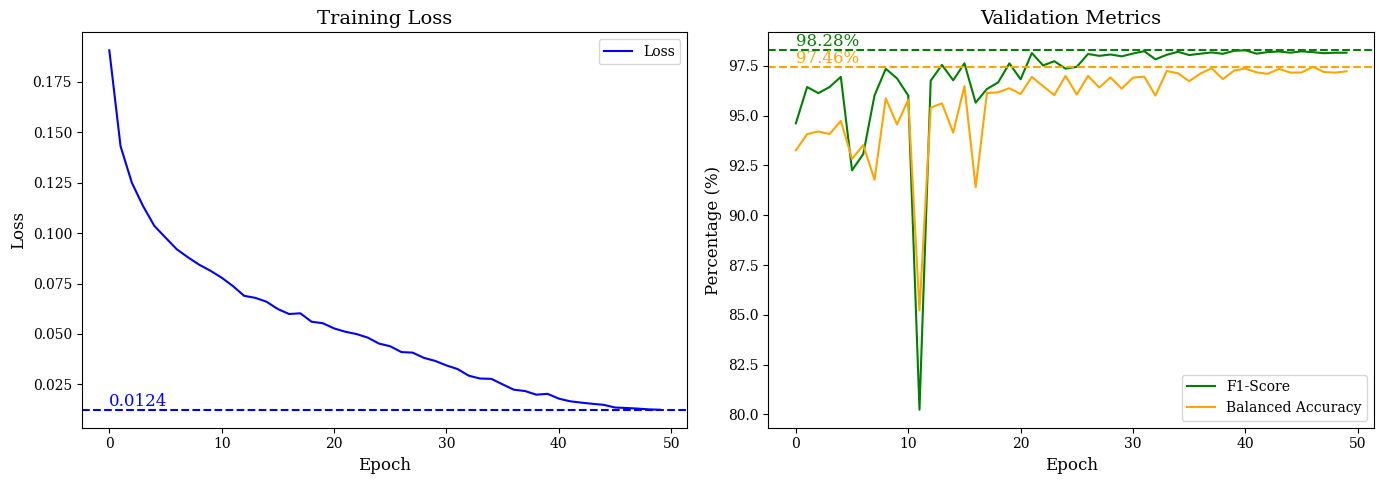

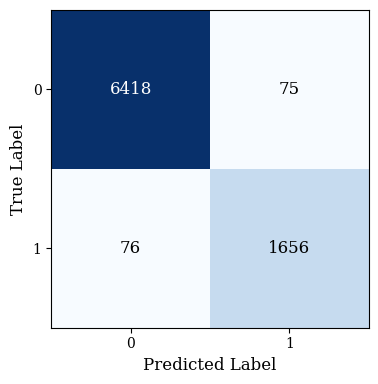

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Use DejaVu Serif as an alternative to Times New Roman
rcParams['font.family'] = 'DejaVu Serif'
rcParams['font.size'] = 12
rcParams['axes.titlesize'] = 14
rcParams['axes.labelsize'] = 12
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
rcParams['legend.fontsize'] = 10

# Plot results
# plot_training_results(train_losses, val_accuracies, val_f1_scores, val_bal_accs, val_preds, val_true)
plot_training_results(train_losses, val_f1_scores, val_bal_accs, val_preds, val_true)
# Close HDF5 file
# dataset.close()

In [10]:
dataset = ParticleDataset('dataset/brightfield_particles.hdf5')

torch.Size([16, 201])


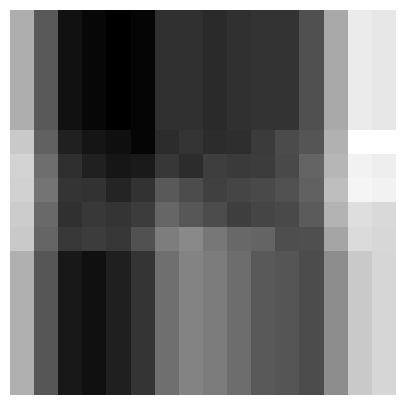

In [11]:
from torchvision.transforms import Resize
import torch
import matplotlib.pyplot as plt
with h5py.File('dataset/brightfield_particles.hdf5', 'r') as f:
    particle_1 = f['data'][f['labels'][:]==0,:][17]
    particle_2 = f['data'][f['labels'][:]==1,:][18]
img = torch.Tensor(particle_1)
print(img.shape)
img = Resize((16,16))(img.unsqueeze(0))
img = img.squeeze(0)
fig, ax = plt.subplots(1, 1, figsize=(10, 5)) 
plt.axis('off')
plt.imshow(img,cmap='gray')
plt.savefig('80nm.png')
plt.show()

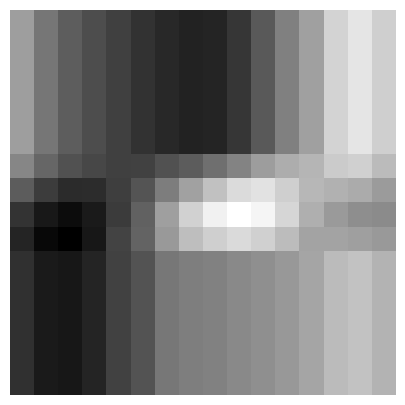

In [12]:
img = torch.Tensor(particle_2)
img = Resize((16,16))(img.unsqueeze(0))
img = img.squeeze(0)
fig, ax = plt.subplots(1, 1, figsize=(10, 5)) 
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.savefig('300nm.png')
plt.show()

In [13]:
import h5py

def get_nd2_paths(base_path, option):
    """
    Recursively collects paths to .nd2 files inside specified subfolders of Metasurface directories.

    Args:
        base_path (str): The base directory to search.
        option (str): The folder to consider ('Brightfield' or 'Laser').

    Returns:
        list: A list of paths to .nd2 files.
    """
    if option not in {'Brightfield', 'Laser'}:
        raise ValueError("Option must be 'Brightfield' or 'Laser'")
    
    nd2_paths = []
    
    for root, dirs, files in os.walk(base_path):
        if 'Metasurface' in os.path.basename(root):
            target_folder = os.path.join(root, option)
            if os.path.isdir(target_folder):
                for file in os.listdir(target_folder):
                    if file.endswith('.nd2'):
                        nd2_paths.append(os.path.join(target_folder, file))  
    return nd2_paths
data_path_1 = os.path.join('data', '2024_11_11', 'Metasurface', 'Chip_02')
data_path_2 = os.path.join('data', '2024_11_12', 'Metasurface', 'Chip_01')
data_path_3 = os.path.join('data', '2024_11_29', 'Metasurface', 'Chip_02')
nd2_paths = []
for data_path in [data_path_1, data_path_2,data_path_3]:
    nd2_paths.extend(get_nd2_paths(data_path, 'Brightfield'))

In [14]:
nd2_paths

['data/2024_11_11/Metasurface/Chip_02/Metasurface 01/Brightfield/02_01_BF.nd2',
 'data/2024_11_11/Metasurface/Chip_02/Metasurface 05/Brightfield/02_05_BF.nd2',
 'data/2024_11_11/Metasurface/Chip_02/Metasurface 02/Brightfield/02_02_BF.nd2',
 'data/2024_11_11/Metasurface/Chip_02/Metasurface 04/Brightfield/02_04_BF.nd2',
 'data/2024_11_11/Metasurface/Chip_02/Metasurface 03/Brightfield/02_03_BF.nd2',
 'data/2024_11_12/Metasurface/Chip_01/Metasurface 01/Brightfield/01_01_BF.nd2',
 'data/2024_11_12/Metasurface/Chip_01/Metasurface 05/Brightfield/01_05_BF001.nd2',
 'data/2024_11_12/Metasurface/Chip_01/Metasurface 02/Brightfield/01_02_BF.nd2',
 'data/2024_11_12/Metasurface/Chip_01/Metasurface 06/Brightfield/01_06_BF.nd2',
 'data/2024_11_12/Metasurface/Chip_01/Metasurface 04/Brightfield/01_04_BF.nd2',
 'data/2024_11_12/Metasurface/Chip_01/Metasurface 03/Brightfield/01_03_BF.nd2',
 'data/2024_11_29/Metasurface/Chip_02/Metasurface 01/Brightfield/02_01_BF.nd2',
 'data/2024_11_29/Metasurface/Chip_02

In [15]:
import os
import pandas as pd
import numpy as np

def analyze_particles(nd2_file_paths):
    # Mapping particle size to CSV filenames
    rename_mapping = {
        "80 nm ": "Captured FITC.csv",
        "300 nm ": "Captured TRITC.csv",
        "600 nm ": "Captured Cy5.csv",
    }
    ren = {
        "Captured Cy5.csv":"600 nm",
        "Captured FITC.csv":"80 nm",
        "Captured TRITC.csv":"300 nm"}
        
    particle_sizes = {
        "Captured Cy5.csv": "80 nm",
        "Captured FITC.csv": "300 nm",
        "Captured TRITC.csv": "1300 nm",
    }

    # Prepare results dictionary
    results = {
        "80 nm": {"count": 0, "min_area": None, "max_area": None, "total_area": 0, "areas": []},
        "300 nm": {"count": 0, "min_area": None, "max_area": None, "total_area": 0, "areas": []},
        "600 nm": {"count": 0, "min_area": None, "max_area": None, "total_area": 0, "areas": []},
        "1300 nm": {"count": 0, "min_area": None, "max_area": None, "total_area": 0, "areas": []},
    }

    # Image dimensions for density calculation
    IMAGE_AREA = 2160 * 2560

    for path in nd2_file_paths:
        folder = os.path.dirname(path)

        # Adjust mappings for "2024_11_29" case
        if "2024_11_29" in path:
            a = ren
        else:
            a = particle_sizes
        for csv_file, size_label in a.items():
            csv_path = os.path.join(folder, csv_file)

            if os.path.exists(csv_path):
                df = pd.read_csv(csv_path)

                # Compute areas
                areas = (df["xMax"] - df["xMin"]) * (df["yMax"] - df["yMin"])

                # Update results
                results[size_label]["count"] += len(areas)
                results[size_label]["total_area"] += areas.sum()
                results[size_label]["areas"].extend(areas)

    # Final calculations for stats
    total_particles = sum(results[size]["count"] for size in results)

    for size, stats in results.items():
        if stats["count"] > 0:
            stats["min_area"] = np.min(stats["areas"])
            stats["max_area"] = np.max(stats["areas"])
            stats["avg_area"] = np.mean(stats["areas"])
            stats["std_area"] = np.std(stats["areas"])
            stats["density"] = stats["count"] / IMAGE_AREA  # Particles per unit area
            stats["percentage"] = (stats["count"] / total_particles) * 100

        # Remove 'areas' list to save memory
        del stats["areas"]

    return results

In [16]:
out = analyze_particles(nd2_paths)
out

{'80 nm': {'count': 32462,
  'min_area': 16.0,
  'max_area': 156.0,
  'total_area': 1093005.0,
  'avg_area': 33.670291417657566,
  'std_area': 14.66897608056359,
  'density': 0.005870587384259259,
  'percentage': 78.50544135429263},
 '300 nm': {'count': 8659,
  'min_area': 16.0,
  'max_area': 132.0,
  'total_area': 303874.0,
  'avg_area': 35.09342880240212,
  'std_area': 11.802183555531926,
  'density': 0.0015659360532407408,
  'percentage': 20.94074969770254},
 '600 nm': {'count': 169,
  'min_area': 16.0,
  'max_area': 110.0,
  'total_area': 8644.0,
  'avg_area': 51.14792899408284,
  'std_area': 27.478803210628538,
  'density': 3.056278935185185e-05,
  'percentage': 0.40870616686819833},
 '1300 nm': {'count': 60,
  'min_area': 16.0,
  'max_area': 324.0,
  'total_area': 3239.0,
  'avg_area': 53.983333333333334,
  'std_area': 61.818953853616414,
  'density': 1.0850694444444445e-05,
  'percentage': 0.14510278113663846}}

In [17]:
import torch
from monai.networks.utils import one_hot
a=torch.rand((32,1,16,16))
print(a.shape)

torch.Size([32, 1, 16, 16])


In [18]:
print(torch.sigmoid(a[0]))

tensor([[[0.5552, 0.7089, 0.5943, 0.5410, 0.6268, 0.6665, 0.5441, 0.5177,
          0.6814, 0.6928, 0.5995, 0.5531, 0.7300, 0.6430, 0.6590, 0.7152],
         [0.7278, 0.5865, 0.6677, 0.6602, 0.6355, 0.5802, 0.6275, 0.6801,
          0.5386, 0.6195, 0.6511, 0.5457, 0.6890, 0.6699, 0.5845, 0.6105],
         [0.6374, 0.6803, 0.5958, 0.5596, 0.5234, 0.5744, 0.6419, 0.5279,
          0.6160, 0.5499, 0.5714, 0.5423, 0.6900, 0.7251, 0.7270, 0.5671],
         [0.6744, 0.6984, 0.6519, 0.6448, 0.7014, 0.6838, 0.6004, 0.6517,
          0.6618, 0.5599, 0.6363, 0.7074, 0.5159, 0.6985, 0.5771, 0.7240],
         [0.6231, 0.6261, 0.7206, 0.6803, 0.7056, 0.6736, 0.6337, 0.6106,
          0.6924, 0.5781, 0.6647, 0.6933, 0.5615, 0.6601, 0.6282, 0.5005],
         [0.5529, 0.5458, 0.5853, 0.7238, 0.6896, 0.5259, 0.5286, 0.6071,
          0.6208, 0.5688, 0.6238, 0.6791, 0.6606, 0.5302, 0.5786, 0.6732],
         [0.6707, 0.6055, 0.5556, 0.6185, 0.6303, 0.6600, 0.5662, 0.5354,
          0.5573, 0.6195, 0.6300